In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##########################################################################################
# UTILITIES CODE. RUN THIS CELL BEFORE EXECUTING ANYTHING ELSE IN THIS NOTEBOOK
##########################################################################################

# This ensures the same model, data and parâmeters produce repeatable results ############
import numpy as np
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(3)
##########################################################################################

import os
import matplotlib.pyplot as plt
import cv2 as cv


# IMAGE FUNCTIONS ########################################################################

# Loads images from images folder and splits in train and test datasets 
def loadImages(images_path, batch_size, imgHeight, imgWidth):
    import tensorflow as tf

    train_set = tf.keras.preprocessing.image_dataset_from_directory(
        directory = images_path,
        labels="inferred",
        label_mode="categorical",
        class_names=None,
        batch_size = batch_size,
        color_mode = "rgb",
        image_size = (imgHeight, imgWidth),
        interpolation = "bilinear",
        seed = 700,
        shuffle = True,
        validation_split = 0.125,
        subset = 'training'
    ).map(lambda x, y: (x/255.0, y) )

    test_set = tf.keras.preprocessing.image_dataset_from_directory(
        directory = images_path,
        labels="inferred",
        label_mode="categorical",
        class_names=None,
        batch_size = batch_size,
        color_mode = "rgb",
        image_size = (imgHeight, imgWidth),
        interpolation = "bilinear",
        seed = 700,
        shuffle = True,
        validation_split = 0.125,
        subset = 'validation'
    ).map(lambda x, y: (x/255.0, y) )

    return( train_set, test_set)

# Functions for converting datasets in generators, required by model.fit 
def getFormatedBatches(dataset):
   for batch in dataset:
      (imagesBatch, labelsBatch) = batch
      yield ( imagesBatch, labelsBatch )

def datasetToGenerator(dataset):
    import itertools
    return itertools.cycle(getFormatedBatches(dataset))


# MODEL COMPONENTS #######################################################################

# EXTRACT PATCH FROM IMAGE
def getPatch(image, patch_h, patch_w, index_h, index_w):
    height = image.shape[1]
    width = image.shape[2]
    return image[:, (index_h*patch_h):((index_h+1)*patch_h), 
                 (index_w*patch_w):((index_w+1)*patch_w), :]

# CNN BLOCK
def cnnBlock(input):
    from keras import layers

    norm = layers.BatchNormalization()(input)
    conv1 = layers.Conv2D( filters=16, kernel_size=(3,3), activation = 'relu')(norm)
    pool1 = layers.MaxPooling2D((2,2))(conv1)

    conv2 = layers.Conv2D( filters=16, kernel_size=(3,3), activation = 'relu')(pool1)
    #pool2 = layers.MaxPooling2D((2,2))(conv2)

    drop = layers.Dropout(0.4)(conv2)

    return drop

# BAGNET BLOCK
def bagnetBlock(input, patchHeight, patchWidth, h, w):
    import keras
    from keras import layers
    
    patch = getPatch(input, patchHeight, patchWidth, h, w)
    cnn = cnnBlock(patch)
    flat = layers.Flatten()(cnn)
    dense = layers.Dense(2, activation='linear')(flat)  # 2 classes: Dandelion and Sunflower 
    return dense

# BUILDS MODEL
def buildModel(imgHeight, imgWidth, patchHeight, patchWidth):
    import keras
    from keras import initializers
    from keras import layers
    from keras import models

    if( imgHeight % patchHeight != 0 ):
        print('Wrong ratio between image height and patch height!')
        return None
    if( imgWidth % patchWidth != 0 ):
        print('Wrong ratio between image width and patch width!')
        return None

    nRows = int(imgHeight / patchHeight)
    nCols = int(imgWidth / patchWidth)

    input = layers.Input(shape=(imgHeight, imgWidth, 3))
    heatmaps = []
    for h in range(nRows):
        for w in range(nCols):
            heatmaps.append( bagnetBlock(input, patchHeight, patchWidth, h, w) )

    classAvgs = layers.Average()(heatmaps)
    softmax = keras.activations.softmax(classAvgs, axis=-1)

    model = models.Model( inputs=input, outputs=softmax )

    return model



In [ ]:
# Images size
IM_HEIGHT = 256
IM_WIDTH = 256
PATCH_HEIGHT = 16
PATCH_WIDTH = 16

BATCH_SIZE = 128

images_path = "/content/drive/My Drive/projects/ds_projects/explainable.dnn/images"


( train_set, test_set ) = loadImages(images_path, BATCH_SIZE, IM_HEIGHT, IM_WIDTH)
train_generator = datasetToGenerator(train_set)
test_generator =  datasetToGenerator(test_set)


Found 2048 files belonging to 2 classes.
Using 1792 files for training.
Found 2048 files belonging to 2 classes.
Using 256 files for validation.


In [ ]:
# Builds Model
model = buildModel(IM_HEIGHT, IM_WIDTH, PATCH_HEIGHT, PATCH_WIDTH)
model.summary()


A saída de streaming foi truncada nas últimas 5000 linhas.
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_40 (S  (None, 16, 16, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_41 (S  (None, 16, 16, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_42 (S  (None, 16, 16, 3)   0           ['input_1[0][0]']                
 licingOpLambda)                                  

Epoch 1/64
14/14 [==============================] - 175s 3s/step - loss: 0.6465 - auc: 0.8802 - val_loss: 0.6633 - val_auc: 0.7999
Epoch 2/64
14/14 [==============================] - 20s 1s/step - loss: 0.5894 - auc: 0.9226 - val_loss: 0.6427 - val_auc: 0.8202
Epoch 3/64
14/14 [==============================] - 20s 1s/step - loss: 0.5438 - auc: 0.9290 - val_loss: 0.6199 - val_auc: 0.8515
Epoch 4/64
14/14 [==============================] - 21s 2s/step - loss: 0.5023 - auc: 0.9312 - val_loss: 0.5941 - val_auc: 0.8816
Epoch 5/64
14/14 [==============================] - 25s 2s/step - loss: 0.4628 - auc: 0.9359 - val_loss: 0.5660 - val_auc: 0.9017
Epoch 6/64
14/14 [==============================] - 26s 2s/step - loss: 0.4272 - auc: 0.9404 - val_loss: 0.5360 - val_auc: 0.9188
Epoch 7/64
14/14 [==============================] - 26s 2s/step - loss: 0.3957 - auc: 0.9444 - val_loss: 0.5054 - val_auc: 0.9313
Epoch 8/64
14/14 [==============================] - 24s 2s/step - loss: 0.3685 - auc: 0.9

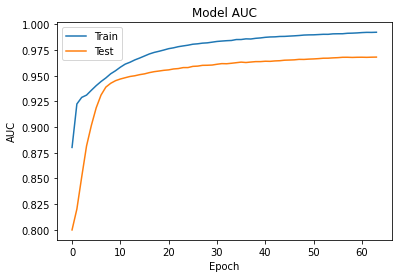

In [ ]:
# COMPILE AND TRAIN THE MODEL ############################################################
NTRAIN_IMAGES = 1792
NVAL_IMAGES = 256
EPOCHS = 64

def trainModel(
    model, train_gen, test_gen, nTrainImages, nTestImages, batchSize, epochs
):
    import matplotlib.pyplot as plt
    from tensorflow.keras.optimizers import Adam, RMSprop
    from tensorflow.keras.losses import BinaryCrossentropy
    from tensorflow.keras.metrics import AUC

    opt = RMSprop(learning_rate=0.0001) 
    model.compile(
        optimizer = opt, 
        loss = BinaryCrossentropy(from_logits=False), 
        metrics = [AUC(from_logits=False)] 
    )

    history = model.fit(
        train_gen,
        steps_per_epoch = nTrainImages // batchSize,
        epochs = epochs,
        validation_data = test_gen,
        validation_steps = nTestImages // batchSize,
        shuffle = False
    )

    # Plots model train, val metrics history
    historyKeys = list(history.history.keys())
    plt.plot(history.history[historyKeys[1]])
    plt.plot(history.history[historyKeys[3]])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    return history

history = trainModel(
    model, train_generator, test_generator, 
    NTRAIN_IMAGES, NVAL_IMAGES, BATCH_SIZE, EPOCHS)


In [ ]:
models_path = "/content/drive/My Drive/projects/ds_projects/explainable.dnn/models/"

model.save(models_path + "bagnets.model")

INFO:tensorflow:Assets written to: /content/drive/My Drive/projects/dandelion_sunflower/models/train.24x32.cnn2.dense_linear.avg.softmax/assets
